# Batch normalisation for a convolution neural network

We compare the performance of adding a batch normalisation layer to a convolution neural network (CNN). For this we use the results from a previous post on creating a CNN for fashion MNIST data.

[https://github.com/stanton119/data-analysis/blob/master/FashionCNN/fashion_cnn.ipynb]

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

tfk = tf.keras
tfkl = tf.keras.layers

## Data prep
The following code is copied from the previous post here:
[https://github.com/stanton119/data-analysis/blob/master/FashionCNN/fashion_cnn.ipynb]

In [2]:
datasets, datasets_info = tfds.load(
    name="fashion_mnist", with_info=True, as_supervised=False, data_dir="data"
)

In [3]:
from tensorflow.keras.utils import to_categorical

train_data = datasets["train"].batch(1000)
train_data = iter(train_data)

# get first batch as training data
batch_1 = next(train_data)
X_train = batch_1["image"].numpy()
Y_train = to_categorical(batch_1["label"].numpy())

# get second batch as testing data
batch_2 = next(train_data)
X_test = batch_2["image"].numpy()
Y_test = to_categorical(batch_2["label"].numpy())

input_shape = datasets_info.features["image"].shape
num_classes = datasets_info.features["label"].num_classes

## Model creation
We create two models - one with batch normalisation layers and one without.

For the batch normalisation model - after each convolution/max pooling layer we add a batch normalisation layer. This layer renormalises the inputs to the subsequent layer. The normalisation is different for each training batch. The idea to prevent covariate shift during training and would hopefully make training converge faster. The batch normalisation layer was originally placed before the activation functions, here it's after, there isn't a concensus about whether they should appear before or after the activation function [link](https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras). When we place it after the activation function is has the effect of renormalising the input data for the subsequent layer, similar to how we usually standardise data before training the network.

The extra layers increase the number of parameters the model has to tune as can be seen below:

In [4]:
def create_model(batch_norm):
    model = tfk.Sequential()
    model.add(
        tfkl.Convolution2D(
            32,
            kernel_size=5,
            input_shape=input_shape,
            activation=tfk.activations.relu,
        )
    )
    model.add(tfkl.MaxPooling2D(pool_size=2))
    if batch_norm:
        model.add(tfkl.BatchNormalization())
    model.add(
        tfkl.Convolution2D(
            32, kernel_size=4, activation=tfk.activations.relu, padding="same"
        )
    )
    model.add(tfkl.MaxPooling2D(pool_size=2))
    if batch_norm:
        model.add(tfkl.BatchNormalization())
    model.add(tfkl.Convolution2D(32, kernel_size=3, activation=tfk.activations.relu))
    model.add(tfkl.Flatten())
    if batch_norm:
        model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(rate=0.2))
    model.add(tfkl.Dense(num_classes))
    model.add(tfkl.Activation("softmax"))
    return model


baseline_model = create_model(batch_norm=False)
bn_model = create_model(batch_norm=True)

print("Baseline model summary:")
baseline_model.summary()
print("")
print("Batch normalisation model summary:")
bn_model.summary()

Baseline model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (No

# Model training
We train both models via the ADAM optimiser for 100 epochs with the same data and associated parameters.

In [5]:
baseline_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

bn_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

history_baseline = baseline_model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size=64,
    epochs=100,
    verbose=False,
)

history_bn = bn_model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size=64,
    epochs=100,
    verbose=False,
)

# Results
Next we plot the fitting history to see how each model converged and performed.

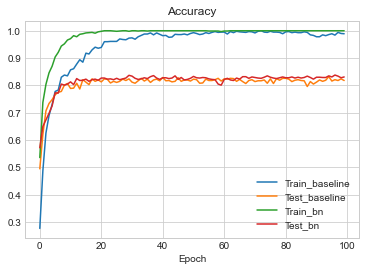

In [6]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.plot(history_baseline.history["accuracy"], label="Train_baseline")
plt.plot(history_baseline.history["val_accuracy"], label="Test_baseline")
plt.plot(history_bn.history["accuracy"], label="Train_bn")
plt.plot(history_bn.history["val_accuracy"], label="Test_bn")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Conclusions

The batch normalisation model converges is far fewer epochs than without using batch normalisation.
After both approaches have converged, the overall performance on the testing set is also marginally better when using batch normalisation.

The increased performance could relate to the fact the batch normalisation model has more parameters to train, which could offer more flexibility in the model. 

More info on batch normalisation:  
https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c